In [202]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [204]:
df = pd.read_csv('Life_Expectancy_No_Missing_Vals.csv').drop('Unnamed: 0', axis = 1)
pd.set_option('display.max_columns', 100)

In [205]:
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,thinness__10-19_years,thinness_5-9_years,gdp,population,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,17.2,17.3,584.259210,33736494.0,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,17.5,17.5,612.696514,327582.0,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,17.7,17.7,631.744976,31731688.0,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,17.9,18.0,669.959000,3696958.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,18.2,18.2,63.537231,2978599.0,0.454,9.5


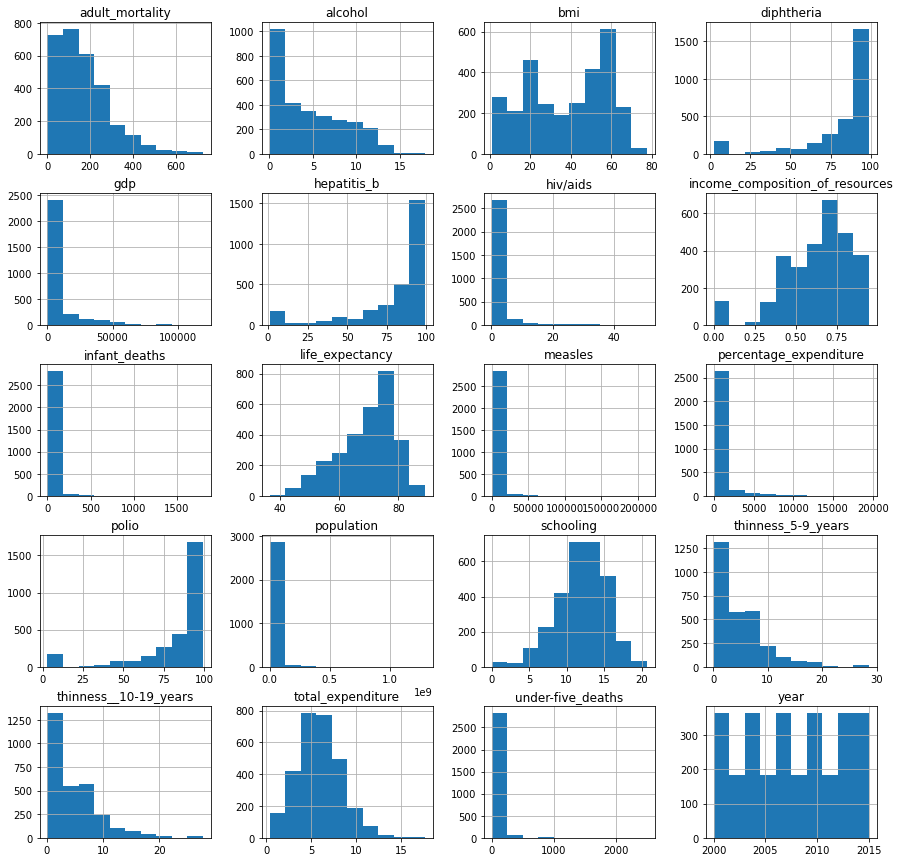

In [206]:
# distribution of the different continuous variables
df.hist(figsize = (15,15))
plt.show()

# EDA #

## Does life expectancy differ between 'developed' and 'developing' countries? ##
- In this section we determine if there is a statistically significant difference in the life expectacy between 'developed' and 'developing' contries.
- This will be used to guide our selection of features for our model.
- We will conduct a two-sample t-test to determine significance using the following hypotheses and alpha level:

$H_{0}$: There is no difference in mean life expectancy between developed and developing countries.

$H_{A}$: There is a difference in mean life expectancy between developed and developing countries. 

$\alpha$ = 0.05

In [47]:
# find the mean life expectancy for developed and developing countries
df.groupby('status').mean()['life_expectancy']

status
Developed     79.197852
Developing    67.111465
Name: life_expectancy, dtype: float64

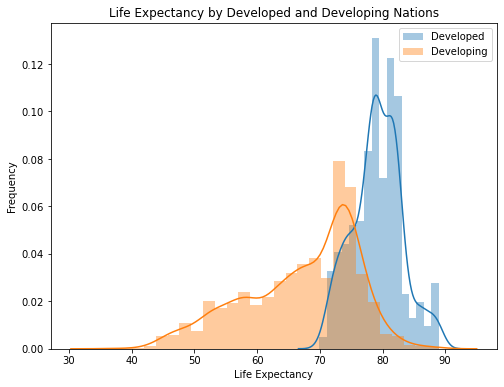

In [41]:
# plot the distribution of life expectancy for developed and developing countries
plt.figure(figsize = (8, 6))
sns.distplot(df[df.status == 'Developed']['life_expectancy'])
sns.distplot(df[df.status == 'Developing']['life_expectancy'])
plt.legend(['Developed', 'Developing'])
plt.title('Life Expectancy by Developed and Developing Nations')
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.show()

It appears that developed nations have a higher mean life lfe expectancy. Is his difference significant? We can run a t-test to determine this. However, in order to do so both samples must have a normal distribution. We'll run some simulations to get a normally distributed data to be able to run a t-test.

In [60]:
# create subset
developed = df[df.status == 'Developed']['life_expectancy']
developing = df[df.status == 'Developing']['life_expectancy']

In [129]:
# ttest on just original data that was not normally distributed
stats.ttest_ind(developed, developing, equal_var = False)

Ttest_indResult(statistic=47.86840603524898, pvalue=2e-323)

Since out T-test returned a p-value < $\alpha$. We reject the null hypothesis and say that there is a statistically significant difference in the mean life expectancies between developed and developing countries. But what features create that difference?

## Does a greater alcohol consumption contribute to greater life expectancy? ##
- In this section, we will see if there is a correlation between alcohol consumption and life expectancy.
- 

$H_{0}$: Greater alcohol consumption does not affect life expectancy.

$H_{A}$: Greater alcohol consumption contributes to greater life expectancy.

$\alpha$ = 0.05

To begin answering this question, we will see if there is a correlation between alcohol consumption and life expectancy. To do this we will run a correlation test.

(0.40810919345874413, 6.333730213961134e-118)


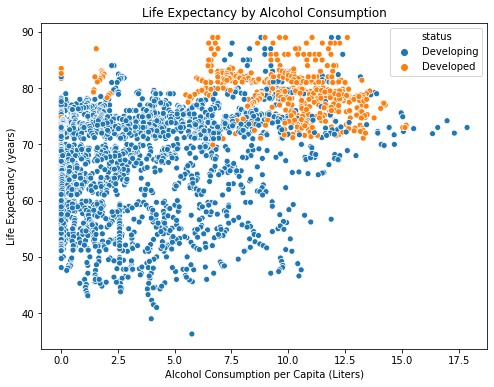

In [131]:
print(stats.pearsonr(df.alcohol, df.life_expectancy))
plt.figure(figsize = (8,6))
sns.scatterplot(data = df, x = 'alcohol', y = 'life_expectancy', hue = 'status')
plt.title('Life Expectancy by Alcohol Consumption')
plt.ylabel('Life Expectancy (years)')
plt.xlabel('Alcohol Consumption per Capita (Liters)')
plt.show()

Based on the correlation correlation test and the scatterplot, there seems to be a positive correlation between alcohol consumption and life expectancy: as alcohol consumption increases, life expectancy seems to increase. To further investigate this, we will group our data by alcohol consumption based on whether a country drinks more or less than the median alcohol consumption. It is worth noting that 'developed' countries tend to have life expectancy greater than 70 and alcohol consumption above the mean value. This can be indicative of underlying factors that contribute to the correlation we are seeing.

In [96]:
# create new column called alcohol_amount based on whether or not alcohol consumption is greater than the median
df['alcohol_amount'] = np.where(df.alcohol > df.alcohol.median(), 1, 0)

In [103]:
# median life expectancy by alcohol consumption group
df.groupby('alcohol_amount').median()['life_expectancy']

alcohol_amount
0    67.3
1    74.4
Name: life_expectancy, dtype: float64

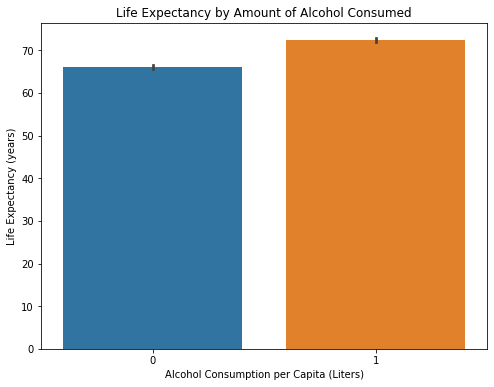

In [112]:
# plot life expectancy by group
plt.figure(figsize = (8,6))
sns.barplot(df.alcohol_amount, df.life_expectancy)
plt.title('Life Expectancy by Amount of Alcohol Consumed')
plt.ylabel('Life Expectancy (years)')
plt.xlabel('Alcohol Consumption per Capita (Liters)')
plt.show()

In [119]:
# run ttest to test for significance
more_alc = df[df.alcohol_amount == 1].life_expectancy
less_alc = df[df.alcohol_amount == 0].life_expectancy

stats.ttest_ind(more_alc, less_alc)

Ttest_indResult(statistic=18.808516327198564, pvalue=1.3597227588003805e-74)

Our t-test shows that there is a significant difference between the life expectancy of countries that drink more alcohol than the median amount. Since the p-value < $\alpha$. This does not paint a whole picture, however. It could be that alcohol consumption is correlated with another feature in our dataframe that has a greater impact on life expectancy and alcohol comsumption may be a proxy for that feature. We can see what other features alcohol is correlated with below.

In [186]:
df.corr()[['alcohol', 'income_composition_of_resources', 'schooling']]

,alcohol,income_composition_of_resources,schooling
year,-0.039865,0.238105,0.210619
life_expectancy,0.408109,0.728873,0.758719
adult_mortality,-0.200263,-0.469962,-0.472010
infant_deaths,-0.116787,-0.159684,-0.208412
alcohol,1.000000,0.469378,0.552024
percentage_expenditure,0.329598,0.367287,0.376585
hepatitis_b,0.120326,0.239416,0.289083
measles,-0.054295,-0.141784,-0.147612
bmi,0.335031,0.503749,0.541762
under-five_deaths,-0.113402,-0.178208,-0.224760


Above, we can see that alcohol is most correlated with schooling and income composition of resources. In turn, both of these are strongly correlated with life expectancy. This tells us that the correlation between alcohol consumption and life expectancy hint at a deeper more, more impactful relationship between other features and life expectancy. To better illustrate, this we can run a multiple regression model to see the impact of alcohol on life expectancy when other features are taken into account. 

## Do the values of schooling change significantly in developed vs developing countries?¶##
- In this section, we will first check the distributions of schooling from these two groups
- Then, we will run a hypothesis test to determine if there is a significant difference
- If we find that there is a difference, we will plot both scatterplots of the two groups data, as well as regression lines for each group. If we find some overlap in the regression lines, then that is strong evidence that there is some interaction between the two variables.
- If we find interaction among the variables, then we will engineer a new interaction feature in our notebook where we build a model

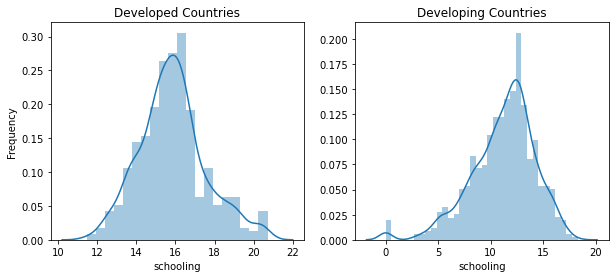

In [190]:
fig = plt.subplots(figsize=(10,4))
ax1 = plt.subplot(121)
sns.distplot(df[df.status=='Developed'].schooling, ax=ax1)
ax1.set_title("Developed Countries")
ax1.set_ylabel("Frequency")

ax2 = plt.subplot(122)
sns.distplot(df[df.status=='Developing'].schooling, ax=ax2)
ax2.set_title("Developing Countries");

Based on the distributions above we can see that they are normal enough to perform some t tests. We want to first run a test to see if schooling changes from developed to developing countries. If we find there is a significant difference, then we will further investigate whether or not there is an interaction between schooling and status when trying to predict life expectancy.

$H_{0}$: Schooling from different country statuses is the same

$H_{a}$: Schooling from different country statuses is not the same

Will run a two sample t test from the two populations using an $\alpha$ of 5%

In [191]:
developed_schooling = df[df.status == 'Developed']
developing_schooling = df[df.status == 'Developing']

In [192]:
x_devd = np.mean(developed_schooling.schooling)
x_devping = np.mean(developing_schooling.schooling)

n_devd = len(developed_schooling)
n_devping = len(developing_schooling)

s_devd = np.std(developed_schooling.schooling)
s_devping = np.std(developing_schooling.schooling)

num = ((n_devd-1)*s_devd**2) + ((n_devping-1)*s_devping**2)
denom = n_devd + n_devping - 2
s_pooled = num / denom

num = x_devd - x_devping
denom = np.sqrt(s_pooled * ((1/n_devd) + (1/n_devping)))
t = num / denom
t

33.52004010972154

Our calculated t statistic, using pooled variances and a 2 sample t test, comes out to 33.5. This is far larger than a t critical value of 1.96 for a 95% condifence test, and so we will reject the null hypothesis. Therefore, we can say with 95% confidence that schooling from developed vs developing countries is different.

In [196]:
plt.figure(figsize=(12,7))

regression_1 = LinearRegression()
regression_2 = LinearRegression()

school_1 = developed_schooling['schooling'].values.reshape(-1, 1)
school_2 = developing_schooling['schooling'].values.reshape(-1, 1)

regression_1.fit(school_1, developed_schooling['life_expectancy'])
regression_2.fit(school_2, developing_schooling['life_expectancy'])

# Make predictions using the testing set
pred_1 = regression_1.predict(school_1)
pred_2 = regression_2.predict(school_2)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)

[0.92596634]
[2.05612325]


<Figure size 864x504 with 0 Axes>

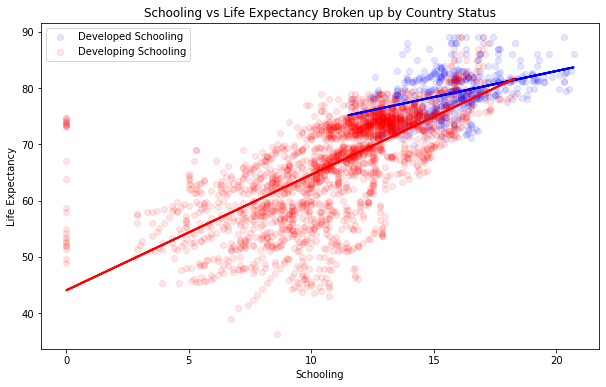

In [197]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.title("Schooling vs Life Expectancy Broken up by Country Status")

plt.scatter(school_1, developed_schooling['life_expectancy'],  color='blue', alpha = 0.1, label = 'Developed Schooling')
plt.scatter(school_2, developing_schooling['life_expectancy'],  color='red', alpha = 0.1, label = 'Developing Schooling')

plt.plot(school_1, pred_1,  color='blue', linewidth=2)
plt.plot(school_2, pred_2,  color='red', linewidth=2)

plt.ylabel('Life Expectancy')
plt.xlabel('Schooling')
plt.legend();

From the above graph, we can see that schooling is far more important in a developing country. Less schooling in a developing country has a strong impact on life expectancy, whereas in a developed country, it is less important. If we were modeling for prediction, we would likely feature engineer a column for this interaction. However, since we are modeling to show relations between predictors that are capable of being changed by a country's government and life expectancy, we will not include this in our model.

In [198]:
X = pd.concat([df, pd.get_dummies(df.status, drop_first=True)], axis=1).drop([
    'country', 'year', 'status', 'life_expectancy'],axis=1)
y = df['life_expectancy']

In [199]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)

X_interact_2 = X.copy()
X_interact_2['school_status'] = X['schooling'] * X['Developing']

In [200]:
import statsmodels.api as sm
X_interact_2 = sm.add_constant(X_interact_2)
model = sm.OLS(y,X_interact_2)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     696.9
Date:                Thu, 10 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:21:42   Log-Likelihood:                -8121.4
No. Observations:                2928   AIC:                         1.629e+04
Df Residuals:                    2906   BIC:                         1.642e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              59.1346      1.767     33.471      0.000      55.670      62.599
adult_mortality                    -0.0176      0.001    -22.791      0.000      -0.019      -0.016
infant_deaths                       0.0960      0.008     11.837      0.000       0.080       0.112
alcohol                            -0.0701      0.040     -1.738      0.082      -0.149       0.009
percentage_expenditure              0.0001   6.77e-05      2.180      0.029    1.49e-05       0.000
hepatitis_b                        -0.0038      0.004     -1.023      0.307      -0.011       0.003
measles                         -1.294e-05   7.35e-06     -1.762      0.078   -2.74e-05    1.46e-06
bmi                                 0.0387      0.005      8.076      0.000       0.029       0.048
under-five_deaths                  -0.0713      0.006    -11.984      0.000      -0.083      -0.060
polio                               0.0267      0.004      6.188      0.000       0.018       0.035
total_expenditure                   0.0035      0.033      0.109      0.913      -0.060       0.067
diphtheria                          0.0306      0.005      6.616      0.000       0.022       0.040
hiv/aids                           -0.4781      0.017    -28.254      0.000      -0.511      -0.445
thinness__10-19_years              -0.0646      0.049     -1.332      0.183      -0.160       0.031
thinness_5-9_years                 -0.0041      0.048     -0.087      0.931      -0.098       0.090
gdp                              3.765e-05   1.02e-05      3.676      0.000    1.76e-05    5.77e-05
population                      -1.437e-09   1.49e-09     -0.966      0.334   -4.36e-09    1.48e-09
income_composition_of_resources     5.7386      0.623      9.209      0.000       4.517       6.961
schooling                           0.5311      0.105      5.074      0.000       0.326       0.736
alcohol_amount                      0.7074      0.280      2.528      0.012       0.159       1.256
Developing                         -5.7589      1.739     -3.311      0.001      -9.169      -2.349
school_status                       0.2952      0.110      2.683      0.007       0.079       0.511
==============================================================================
Omnibus:                      159.411   Durbin-Watson:                   0.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              618.775
Skew:                          -0.058   Prob(JB):                    4.31e-135
Kurtosis:                       5.249   Cond. No.                     2.08e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] Th

# Conclusion #

From the above analyses, we can conclude that there is a significant difference in the life expectancy between 'developed' and 'developing' countries. Afterwards, we conducted analyses on select features, namely alcohol consumption and schooling. In the analysis of alcohol, we saw that alcohol may not be a good feature to include in our model because it may be a proxy another feature. In other words, there maybe a correlation between alcohol consumption and other features in our dataframe which can mean that these features do a better job at explaining the variace of life expectancy. In the above regression model we can see just that: when combined with other features, alcohol is not statistically significant a predictor for life expectancy. This means we may not include it in our final model. In the analysis of schooling, we saw that schooling may be a key factor in predicting life expectancy, especialy considering the impact it has on developing countries. 